# Machine Failure Prediction

# Imports

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import roc_curve as sklearn_roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [19]:
def check_nulls_dupes(df):
  print(f"The amount of nulls: {df.isna().sum()}")
  print(f"The amount of Dupes: {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  rows = len(df.columns)
  dims = (rows+ 3)//4
  for idx, col in enumerate(df.columns):
    plt.subplot(dims, 4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "Hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")
  plt.tight_layout()
  plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(16, 16))
  rows = len(interested_columns)
  dims = (rows + 3 )//4
  
  for idx, col in enumerate(interested_columns):
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    plt.subplot(dims, 4, idx+1)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  
  plt.tight_layout()
  plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def create_pipeline(sample_model, model, kbest=None):
  
  steps = [
    ("sample", sample_model),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(0, ("Feature-Selector", kbest))
  
  return Pipeline(steps= steps
  )

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "DUMMY": DummyClassifier(strategy="stratified")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='weighted')
    precision_metric = precision_score(y, predictions, average='weighted')
    f1_metric = f1_score(y, predictions, average='weighted')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]

def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=3)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(sample_model, model_names, models, X, y, scoring_metric, kbest=None):
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline = create_pipeline(sample_model, model, kbest) if kbest else create_pipeline(sample_model, model) 
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  print(performance_df)

def test_kbest_columns(X, y, sample_model, model, model_name, kbest):
  
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_pipeline(sample_model, model, metric)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)

    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/downloads/data.csv")
df

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0
...,...,...,...,...,...,...,...,...,...,...
939,0,7,7,1,6,4,73,6,24,1
940,0,7,5,2,6,6,50,6,24,1
941,0,3,6,2,7,5,43,6,24,1
942,0,6,6,2,5,6,46,7,24,1


# Check For Nulls & Dupes

In [4]:
check_nulls_dupes(df)

The amount of nulls: footfall       0
tempMode       0
AQ             0
USS            0
CS             0
VOC            0
RP             0
IP             0
Temperature    0
fail           0
dtype: int64
The amount of Dupes: 1


In [5]:
df.drop_duplicates(inplace=True)

# Check Class Imbalance

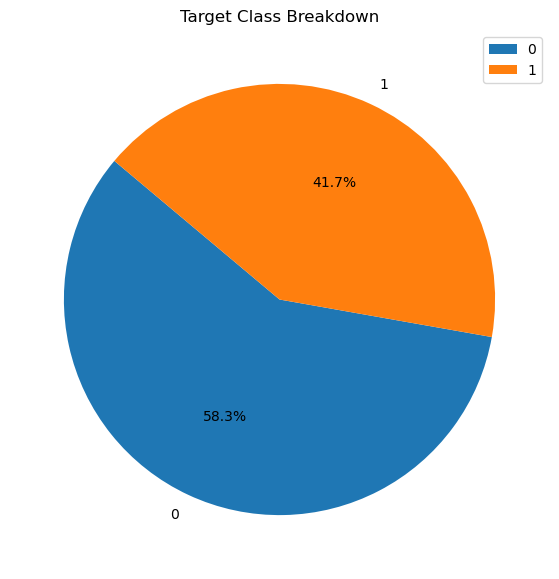

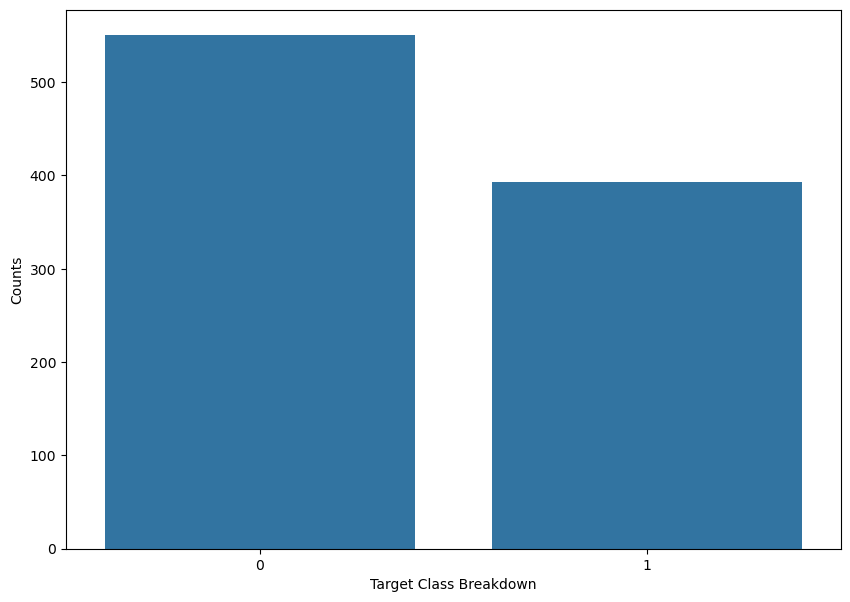

In [7]:
check_class_imbalance(df["fail"])

# Fairly Balanced Dataset

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
footfall,943.0,306.673383,1083.144024,0.0,1.0,22.0,110.0,7300.0
tempMode,943.0,3.726405,2.678334,0.0,1.0,3.0,7.0,7.0
AQ,943.0,4.326617,1.438551,1.0,3.0,4.0,6.0,7.0
USS,943.0,2.939555,1.384458,1.0,2.0,3.0,4.0,7.0
CS,943.0,5.393425,1.269869,1.0,5.0,6.0,6.0,7.0
VOC,943.0,2.844115,2.273751,0.0,1.0,2.0,5.0,6.0
RP,943.0,47.042418,16.431816,19.0,34.0,44.0,58.0,91.0
IP,943.0,4.564157,1.599452,1.0,3.0,4.0,6.0,7.0
Temperature,943.0,16.326617,5.976014,1.0,14.0,17.0,21.0,24.0
fail,943.0,0.416755,0.493283,0.0,0.0,0.0,1.0,1.0


In [14]:
df.dtypes

footfall       int64
tempMode       int64
AQ             int64
USS            int64
CS             int64
VOC            int64
RP             int64
IP             int64
Temperature    int64
fail           int64
dtype: object

# Visuals

<AxesSubplot:>

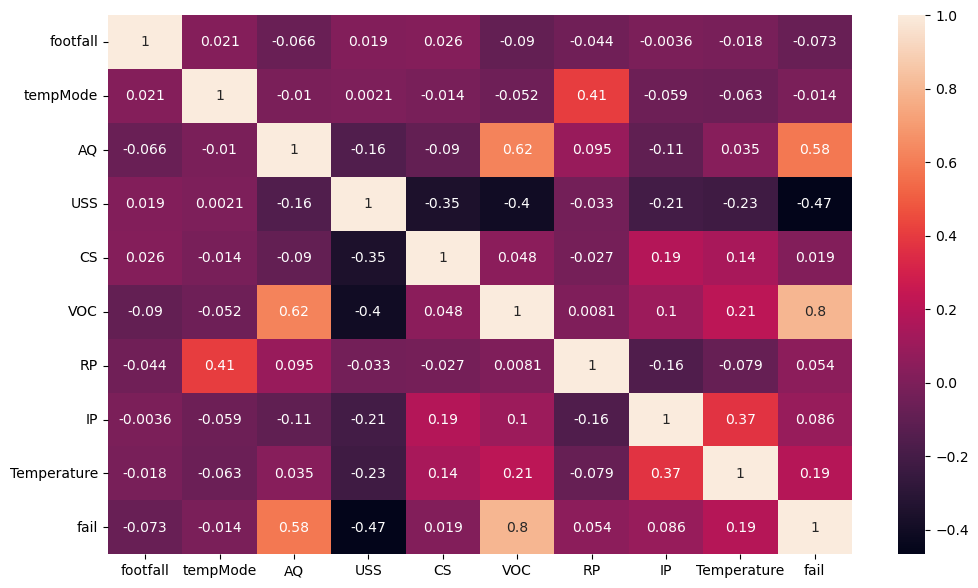

In [12]:
relations = df.corr()
plt.figure(figsize=(12, 7))
sns.heatmap(data=relations, annot=True)

# Histogram

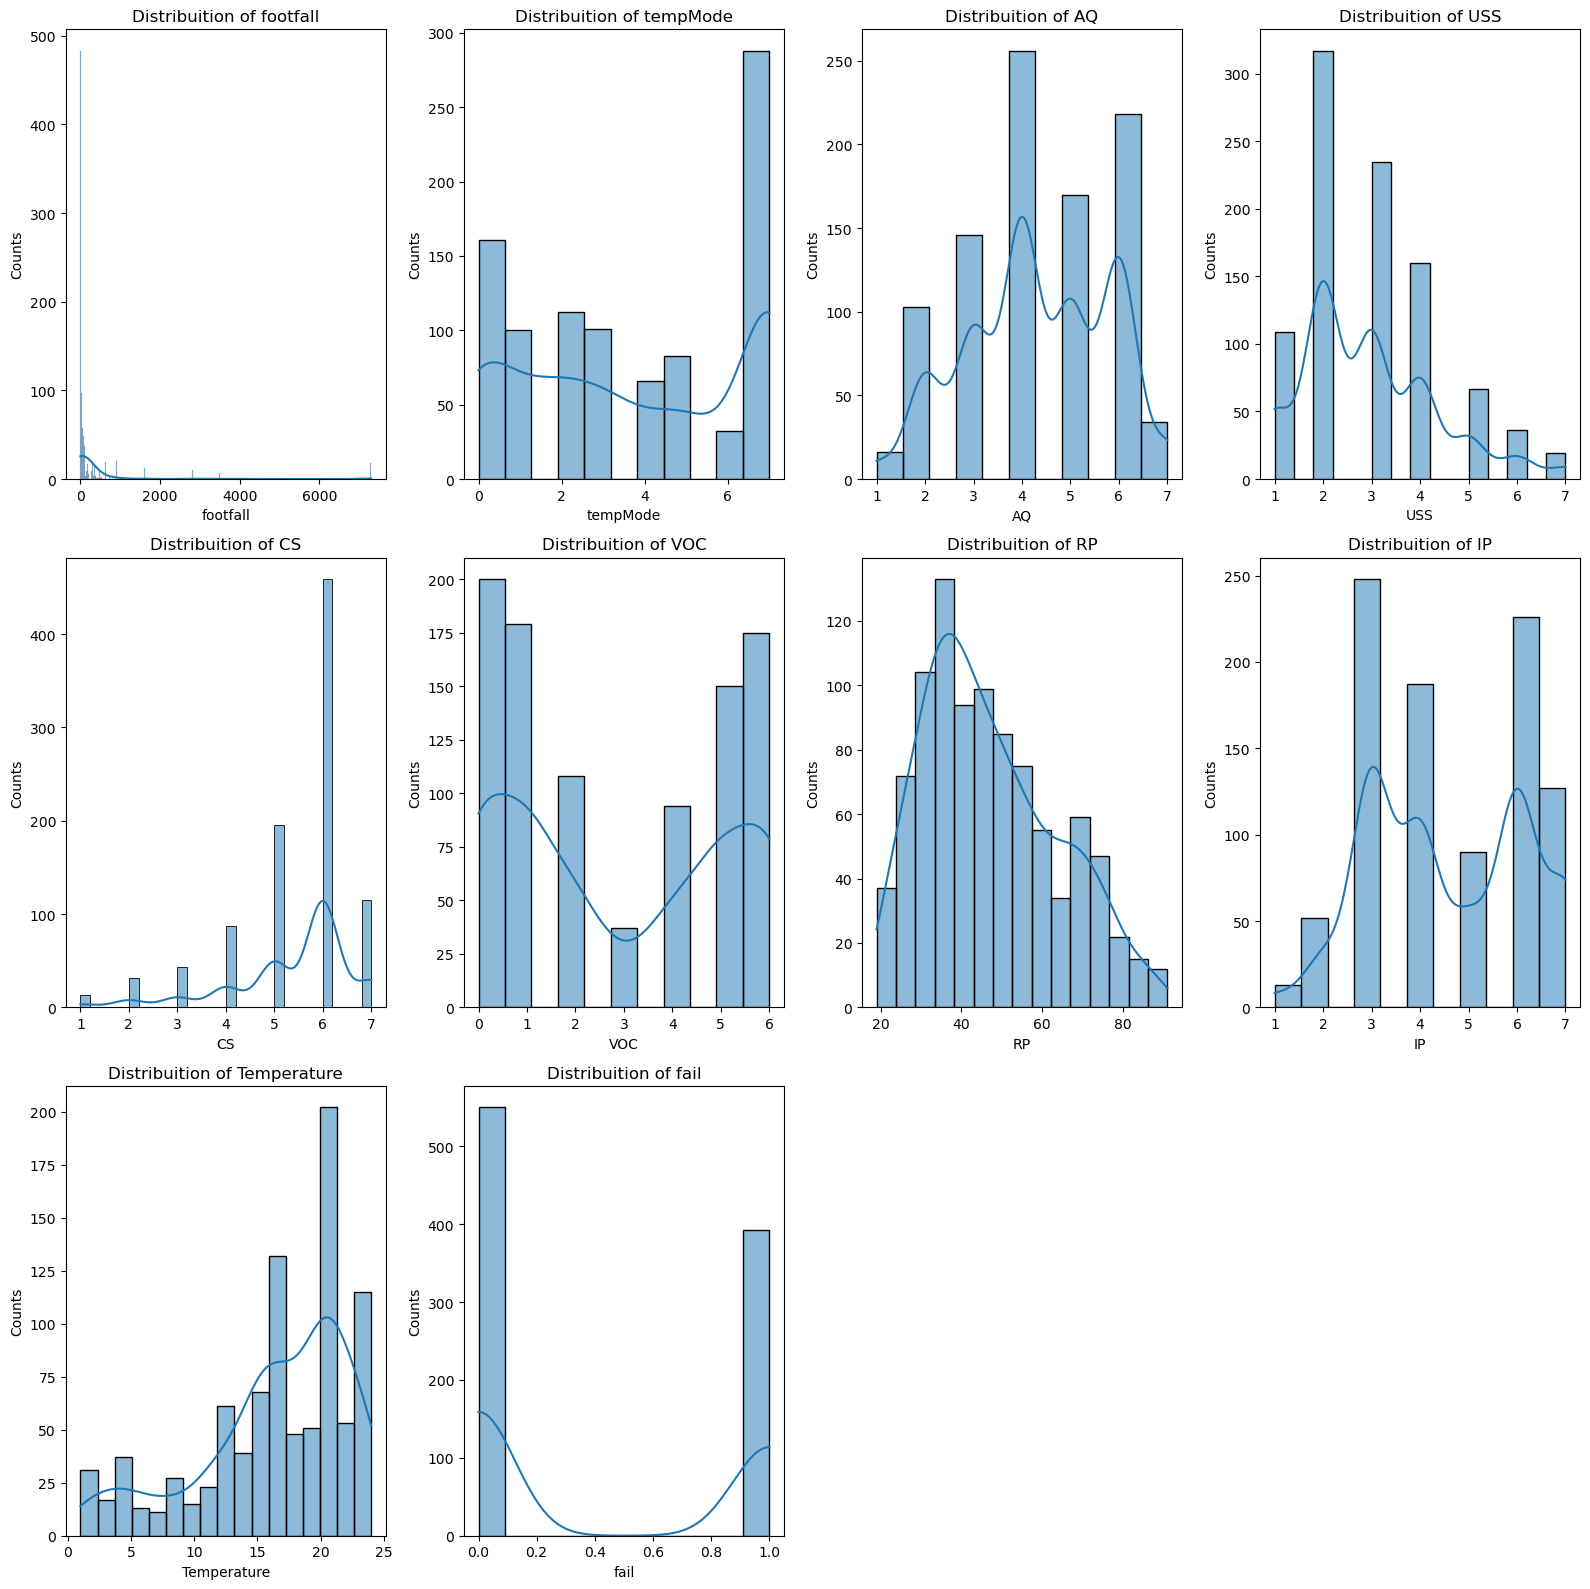

In [18]:
plot_distribution(df,"Hist")

# Aggregate Dataset

# Sum

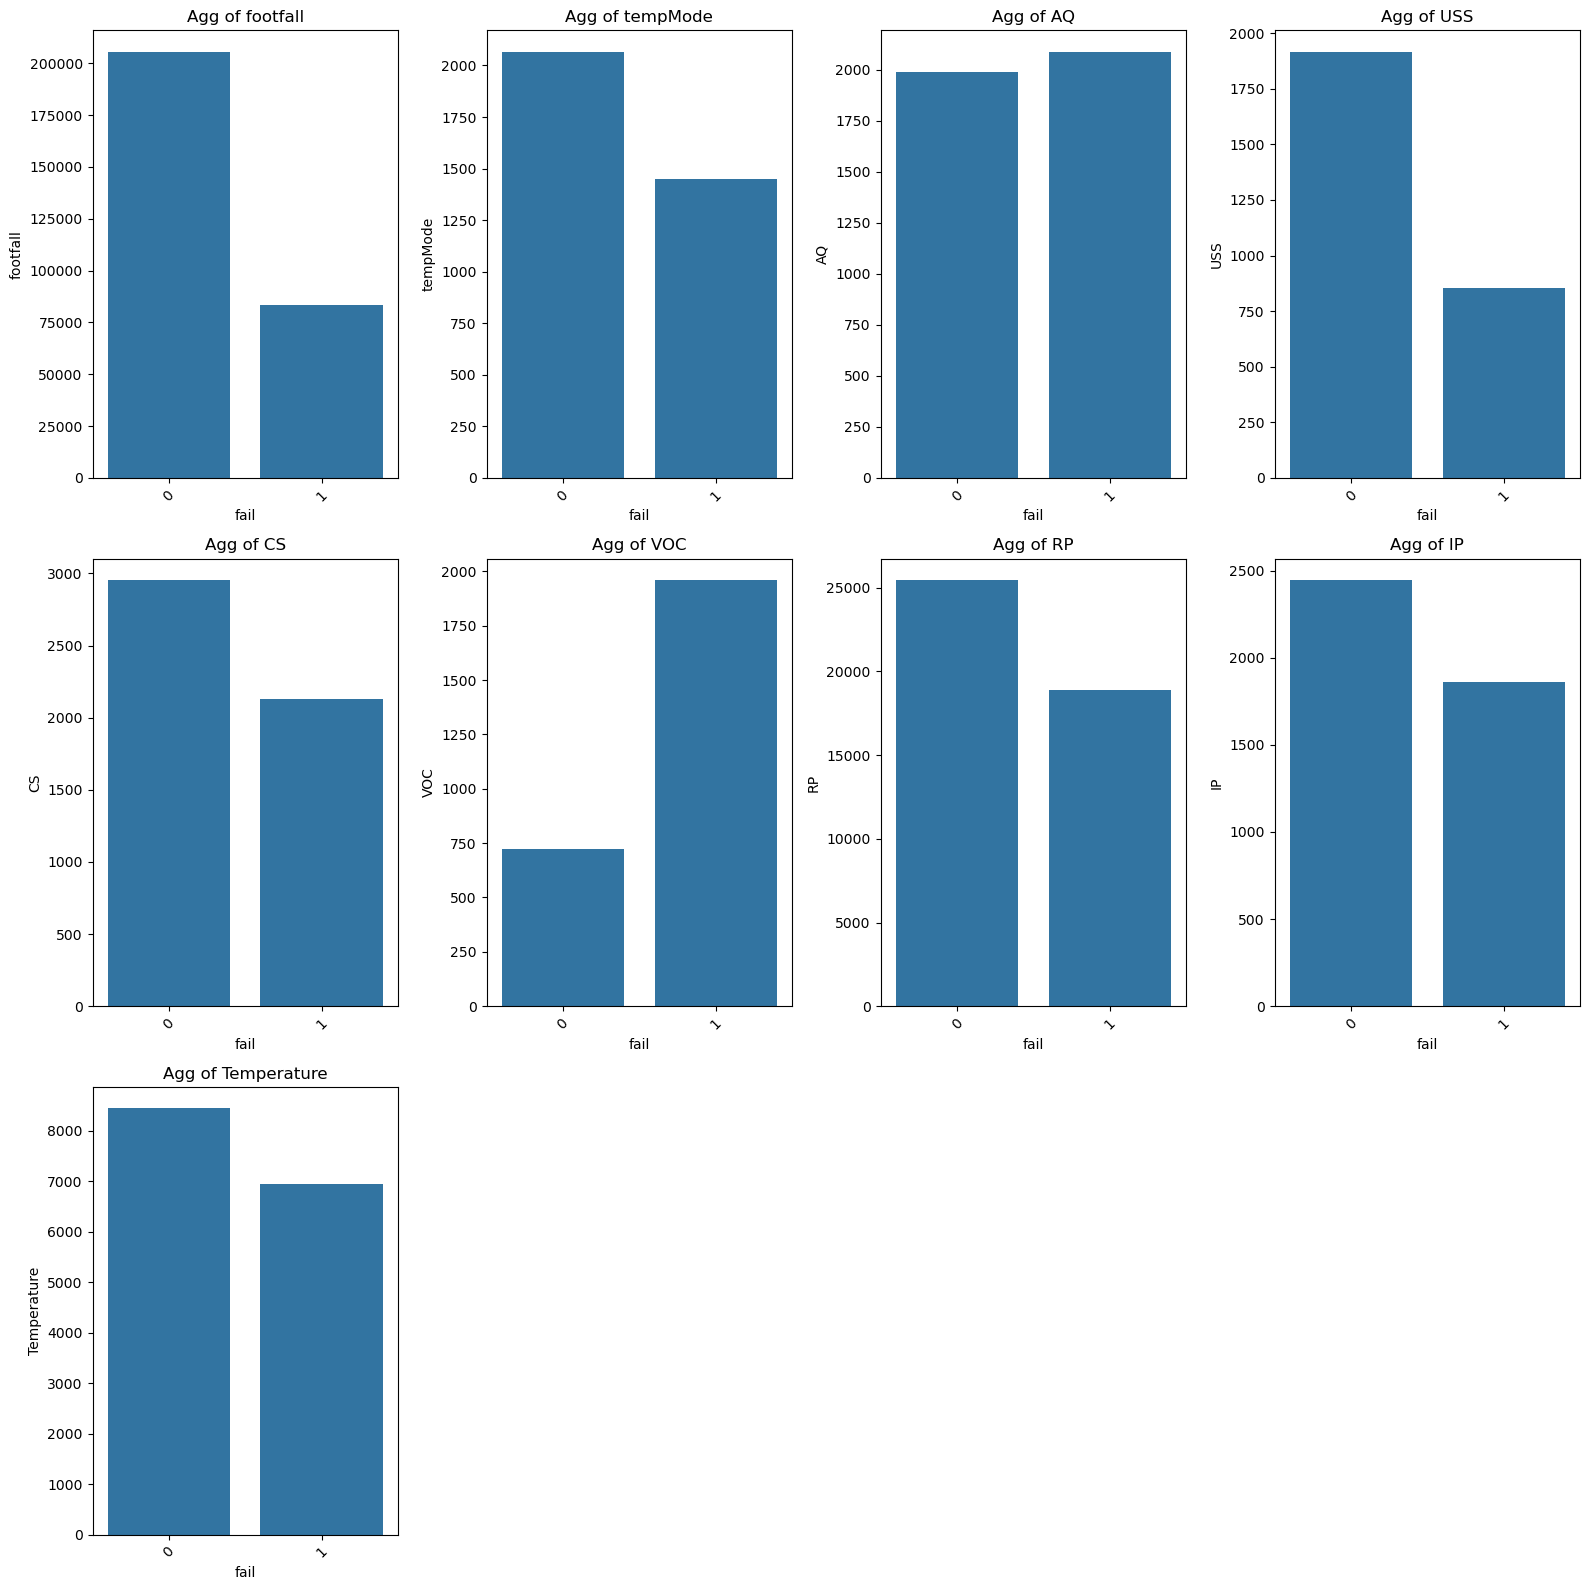

In [22]:
interested_columns = df.drop("fail", axis=1).columns

aggregate_dataset(df, interested_columns, "fail", "sum")

# Mean

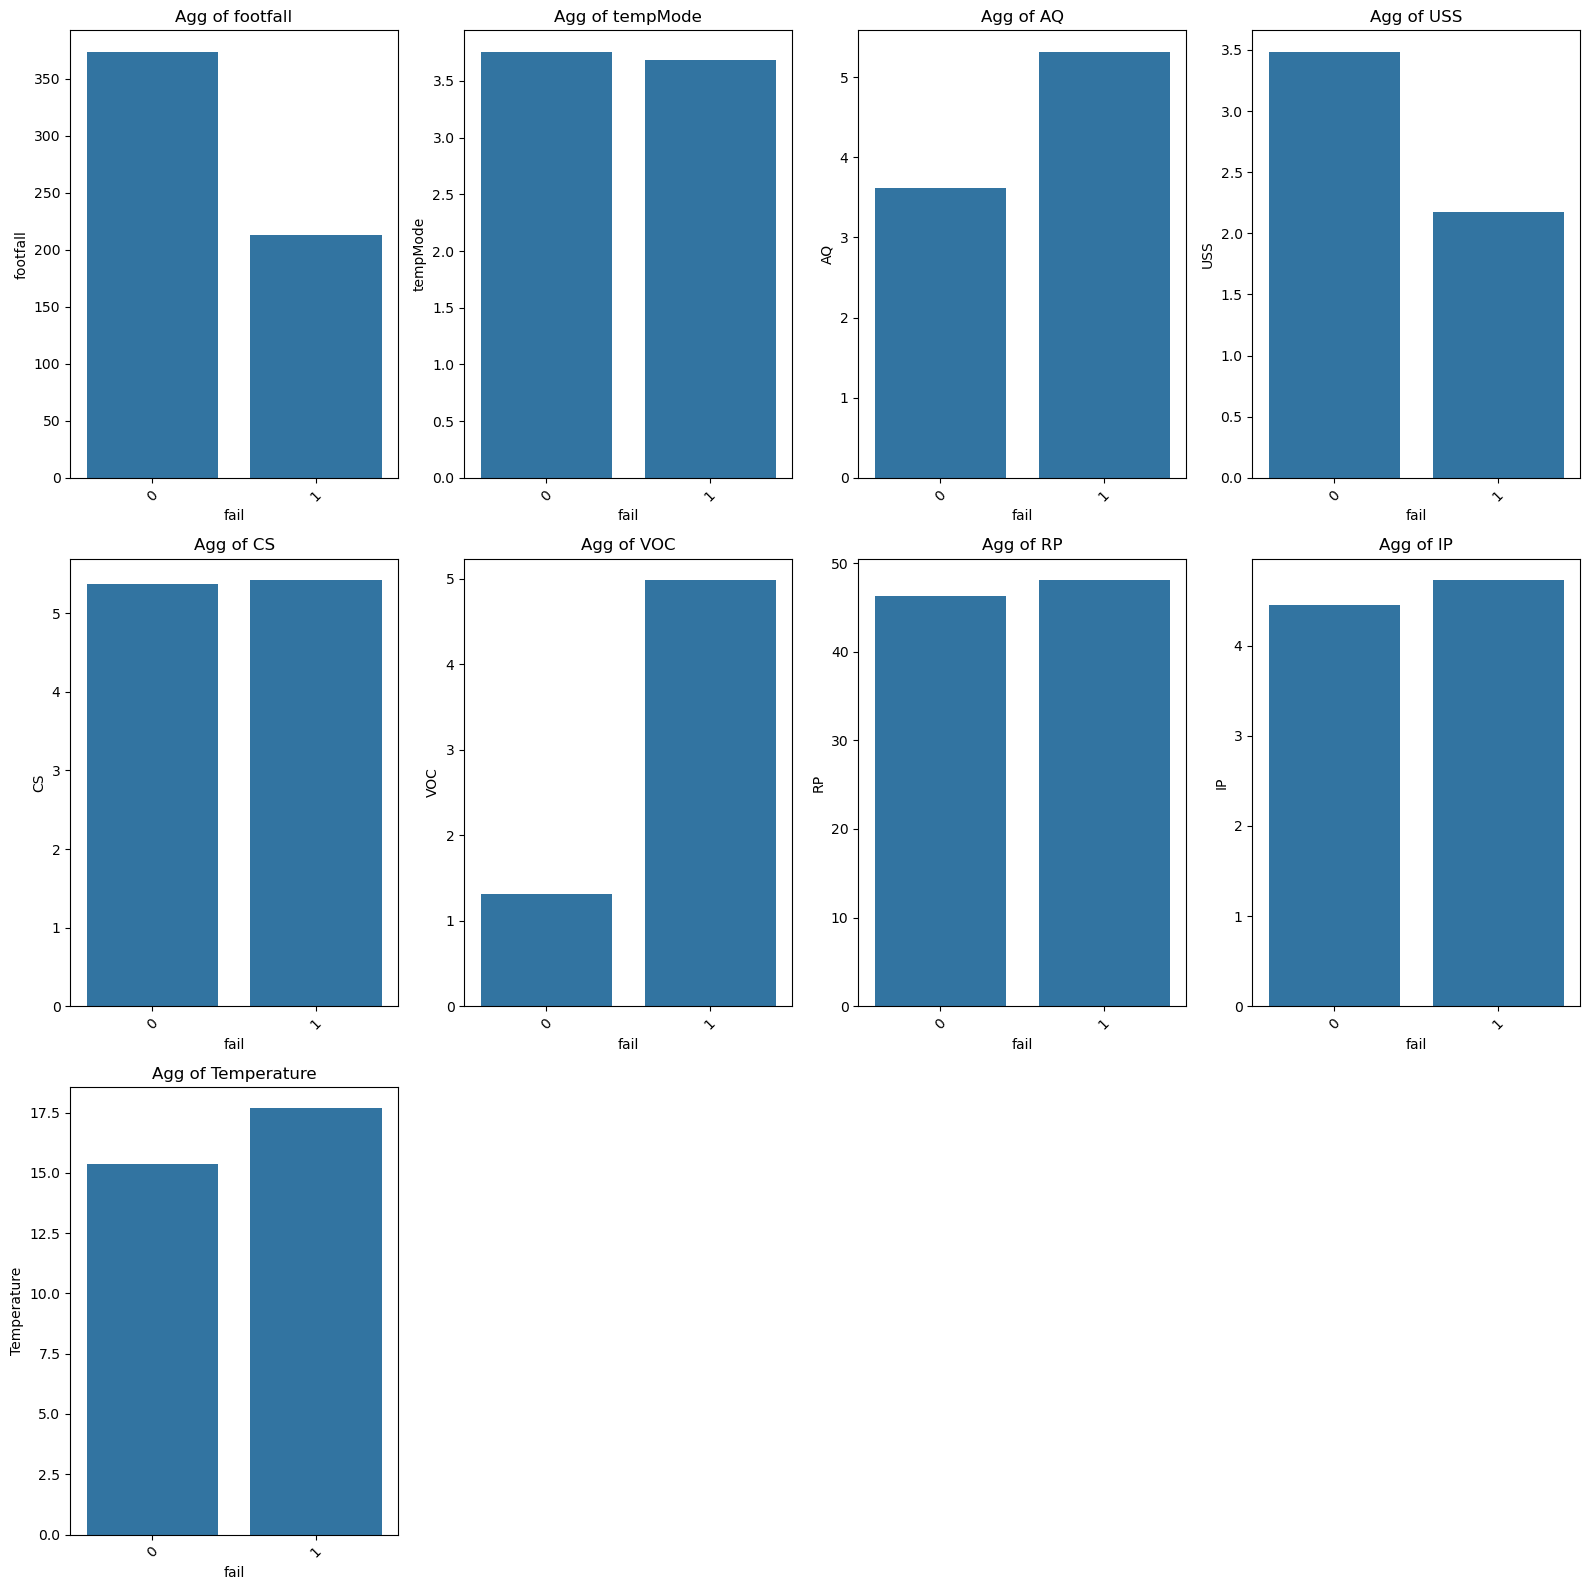

In [23]:
interested_columns = df.drop("fail", axis=1).columns

aggregate_dataset(df, interested_columns, "fail", "mean")

# Separate Variables

# Create Metrics

In [ ]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="weighted")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='weighted')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='weighted')

# Baseline Model Performance

In [ ]:
model_name = ["DUMMY"]
models = grab_selected_models(model_name)
sample_model = SMOTE()
test_selected_models(sample_model, model_name, models, X_pca, y_encoded, acc_metric)